##**Import libraries**

In [ ]:
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error


## **Required Functions**

In [ ]:
def calculate_mva(data, window):
  mva = data['Close'].rolling(window=window).mean()
  return mva

'''
def get_weights(window_size):
  total = 0
  weights = {}
  for i in range(window_size + 1):
    total += i

  for i in range(1, window_size + 1):
    weights[i] = (i/total)

  return weights


def calculate_weighted_mva(data, window):
  weights = get_weights(window)

  moving_averages = [0] * (window - 1)
  for i in range(window - 1, len(data)):
    weighted_sum = sum(data.iloc[i - j]['Close'] * weights[j + 1] for j in range(window))
    moving_averages.append(weighted_sum)

  return moving_averages
'''

def calculate_rsi(data, window):
    delta = data['Close'].diff(1)

    gain = delta.copy()
    loss = delta.copy()

    gain[delta <= 0] = 0
    loss[delta > 0] = 0

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = abs(loss.rolling(window=window, min_periods=1).mean())

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    dates = []  # Store dates separately
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length].values)  # Use .values to get numpy array
        targets.append(data.iloc[i + seq_length]['Close'])  # Use .iloc to access the 'Close' value
        dates.append(data.index[i + seq_length])  # Store date separately
    return np.array(sequences), np.array(targets), dates


def split_data(x, y, ratio=0.2):
    # Calculate the split index
    split_index = int(len(x) * (1 - ratio))

    # Split the data
    x_train = x[:split_index]
    y_train = y[:split_index]
    x_test = x[split_index:]
    y_test = y[split_index:]

    return x_train, x_test, y_train, y_test

def calculate_obv(data):
  obv = [0]
  for i in range(1, len(data)):
    if data['Close'][i] > data['Close'][i - 1]:
      obv.append(obv[i - 1] + data['Volume'][i])
    elif data['Close'][i] < data['Close'][i - 1]:
      obv.append(obv[i - 1] - data['Volume'][i])
    else:
      obv.append(obv[i - 1])

  return obv

def get_history(ticker, period, window):
  # Get raw stock data
  ticker = yf.Ticker(ticker)
  data = ticker.history(period = period)

  # Add RSI field
  data['MVA'] = calculate_mva(data, window)
  data['RSI'] = calculate_rsi(data, window)
  data['OBV'] = calculate_obv(data)
  data = data[data['RSI'].notna() & (data['RSI'] != 0)]
  data = data[data['MVA'].notna()]

  return data

## **OTHER DATA**

In [ ]:
window_size = 20
testing_ratio = 0.2

columns = ['Open', 'Close', 'Volume', 'RSI', 'MVA']
data = get_history("PEP", "10y", window_size)[columns]

print(data)
scaler = MinMaxScaler(feature_range = (0,1))
data[columns] = scaler.fit_transform(data[columns])


x, y, dates = create_sequences(data, window_size)

x_train, x_test, y_train, y_test = split_data(x, y, testing_ratio)


print("Size of y-train:", len(y_train))
print("Size of y-test:", len(y_test))


# Print the shape of the data
print("Data shape:", data.shape)

                                 Open       Close   Volume        RSI  \
Date                                                                    
2014-08-07 00:00:00-04:00   68.032658   67.365746  4625600  50.175973   
2014-08-08 00:00:00-04:00   67.365724   67.657967  4739900  51.506796   
2014-08-11 00:00:00-04:00   68.264958   68.782005  5231100  52.387480   
2014-08-12 00:00:00-04:00   68.534709   68.347374  2776000  52.957194   
2014-08-13 00:00:00-04:00   68.609656   68.744537  3690300  54.111472   
...                               ...         ...      ...        ...   
2024-07-03 00:00:00-04:00  162.919998  162.600006  2879600  26.141791   
2024-07-05 00:00:00-04:00  162.639999  164.389999  4208200  32.563546   
2024-07-08 00:00:00-04:00  163.059998  162.119995  5268800  29.894567   
2024-07-09 00:00:00-04:00  162.190002  161.899994  5801200  30.635587   
2024-07-10 00:00:00-04:00  161.750000  163.589996  7285790  44.267994   

                                  MVA  
Date      

## **Training Model**

In [ ]:
# Build an improved LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, x.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')

hist = model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/25
124/124 [==============================] - 5s 13ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 2/25
124/124 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/25
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/25
124/124 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 5/25
124/124 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 8.0451e-04
Epoch 6/25
124/124 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/25
124/124 [==============================] - 1s 11ms/step - loss: 8.8690e-04 - val_loss: 7.8474e-04
Epoch 8/25
124/124 [==============================] - 1s 8ms/step - loss: 8.9207e-04 - val_loss: 0.0015
Epoch 9/25
124/124 [==============================] - 1s 8ms/step - loss: 8.7607e-04 - val_loss: 6.4204e-04
Epoch 10/25
124/124 [==============================] - 1s 8ms/step - loss

16/16 [==============================] - 1s 3ms/step


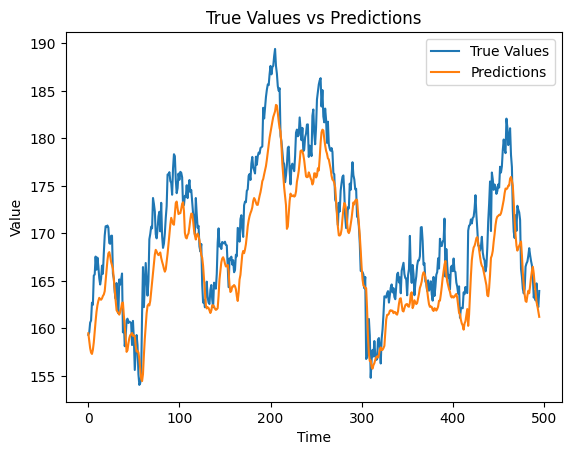

In [ ]:
model.evaluate(x=x_test, y=y_test)
predictions = model.predict(x_test)

zeros_array = np.zeros((predictions.shape[0], 4))

# Concatenate predictions with the zero array
predictions_with_zeros = np.concatenate((predictions, zeros_array), axis=1)
predictions_rescaled = scaler.inverse_transform(predictions_with_zeros)[:,0]

y_test_with_zeros = np.concatenate((y_test.reshape(-1, 1), zeros_array), axis=1)
y_test_rescaled = scaler.inverse_transform(y_test_with_zeros)[:,0]


plt.plot(y_test_rescaled, label='True Values')
plt.plot(predictions_rescaled, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()

In [ ]:
# Calculating error metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 14.81842011013936
Root Mean Squared Error (RMSE): 3.849470107708249
Mean Absolute Error (MAE): 3.2197053268298577


# **Other**

In [ ]:
tick = yf.Ticker("AAPL")

inc_smt = tick.quarterly_income_stmt
bal_sht = tick.quarterly_balance_sheet

print(inc_smt["2024-03-31"])

Tax Effect Of Unusual Items                                             0.0
Tax Rate For Calcs                                                    0.158
Normalized EBITDA                                             30736000000.0
Net Income From Continuing Operation Net Minority Interest    23636000000.0
Reconciled Depreciation                                        2836000000.0
Reconciled Cost Of Revenue                                    48482000000.0
EBITDA                                                        30736000000.0
EBIT                                                          27900000000.0
Net Interest Income                                                     NaN
Interest Expense                                                        NaN
Interest Income                                                         NaN
Normalized Income                                             23636000000.0
Net Income From Continuing And Discontinued Operation         23636000000.0
Total Expens

In [ ]:
# CREATE A TICKER INSTANCE PASSING TESLA AS THE TARGET COMPANY
tsla = yf.Ticker('TSLA')

# CALL THE MULTIPLE FUNCTIONS AVAILABLE AND STORE THEM IN VARIABLES.
calendar = tsla.get_calendar()
cf = tsla.get_cashflow()
info = tsla.get_info()
inst_holders = tsla.get_institutional_holders()
news = tsla.get_news()
recommendations = tsla.get_recommendations()

# PRINT THE RESULTS
print("calendar")
print(calendar)
print('*'*20)
print("cf")
print(cf)
print('*'*20)
print("info")
print(info)
print('*'*20)
print("inst_holders")
print(inst_holders)
print('*'*20)
print("news")
print(news)
print('*'*20)
print("recommendations")
print(recommendations)
print('*'*20)

calendar
{'Earnings Date': [datetime.date(2024, 7, 17), datetime.date(2024, 7, 22)], 'Earnings High': 0.8, 'Earnings Low': 0.38, 'Earnings Average': 0.55, 'Revenue High': 26217800000, 'Revenue Low': 18794300000, 'Revenue Average': 22377800000}
********************
cf
                                              2023-12-31     2022-12-31  \
FreeCashFlow                                4357000000.0   7552000000.0   
RepaymentOfDebt                            -1815000000.0  -3866000000.0   
IssuanceOfDebt                              3931000000.0            0.0   
IssuanceOfCapitalStock                               NaN            0.0   
CapitalExpenditure                         -8899000000.0  -7172000000.0   
InterestPaidSupplementalData                 126000000.0    152000000.0   
IncomeTaxPaidSupplementalData               1119000000.0   1203000000.0   
EndCashPosition                            17189000000.0  16924000000.0   
BeginningCashPosition                      16924000000.0 